In [1]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import seaborn as sns
from matplotlib import colormaps
from result import *
from adjustText import adjust_text

def load_pkl(path):
    with open(path, 'rb') as file:
        loaded_dict = pickle.load(file)
    return loaded_dict

FILTERING_S_ALG = ['S_LONGEST', 'S_EARLIEST', 'S_RANDOM']
FILTERING_C_ALG = ['C_EARLIEST', 'xC_RANDOM']
FILTERING_UE_ALG = ['UE_LONGEST', 'xUE_RANDOM']
FILTERING_ACCESS_OPPORTUNITIES_ALG = ['4', 'x8', 'x12']
FILTER_MAX_AND_MIN = True
FILTER_PERCENT = 1


directory_path = './'
result = {}

# Loop through the files in the directory
for filename in os.listdir(directory_path):
    # Check if the file ends with .pkl
    if filename.endswith('.pkl'):
        source_alg = filename[:-4].split('|')[0]
        candidate_alg = filename[:-4].split('|')[1]
        ue_alg = filename[:-4].split('|')[2]
        access_opportunities = filename[:-4].split('|')[3]
        if (source_alg in FILTERING_S_ALG
        and candidate_alg in FILTERING_C_ALG
        and ue_alg in FILTERING_UE_ALG
        and access_opportunities in FILTERING_ACCESS_OPPORTUNITIES_ALG):
            result[(source_alg, candidate_alg, ue_alg, access_opportunities)] = load_pkl(filename)
            result[(source_alg, candidate_alg, ue_alg, access_opportunities)]['time_sat_matrix'] = np.array(result[(source_alg, candidate_alg, ue_alg, access_opportunities)]['time_sat_matrix'])

result = prepare_result(result, FILTER_MAX_AND_MIN, FILTER_PERCENT)
#result = generate_numerical_results(result, FILTER_MAX_AND_MIN, FILTER_PERCENT)


Those with small max signalling
('S_EARLIEST', 'C_EARLIEST', 'UE_LONGEST', '4')
('S_RANDOM', 'C_EARLIEST', 'UE_LONGEST', '4')
('S_LONGEST', 'C_EARLIEST', 'UE_LONGEST', '4')
Those with large max signalling
('S_EARLIEST', 'C_EARLIEST', 'UE_LONGEST', '4')
('S_RANDOM', 'C_EARLIEST', 'UE_LONGEST', '4')
('S_LONGEST', 'C_EARLIEST', 'UE_LONGEST', '4')


# Main Objective

The signalling peak is the main and the only objective. The measurement is the maximum signalling of any satellite any time.

In [2]:
prepare_result(result)

0.43167956261249046
0.44044435986934277
0.5642728410249399


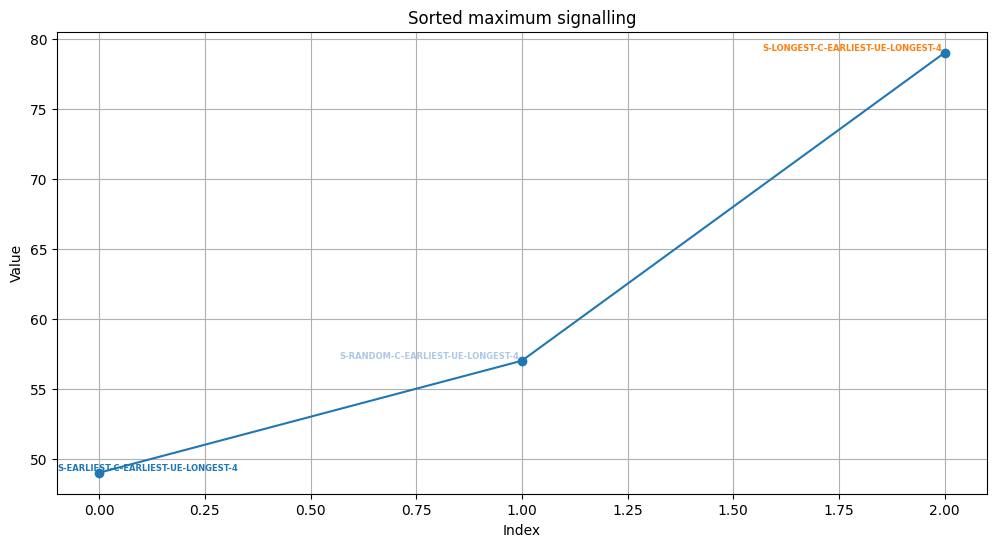

Overall, are we generating more signalling?


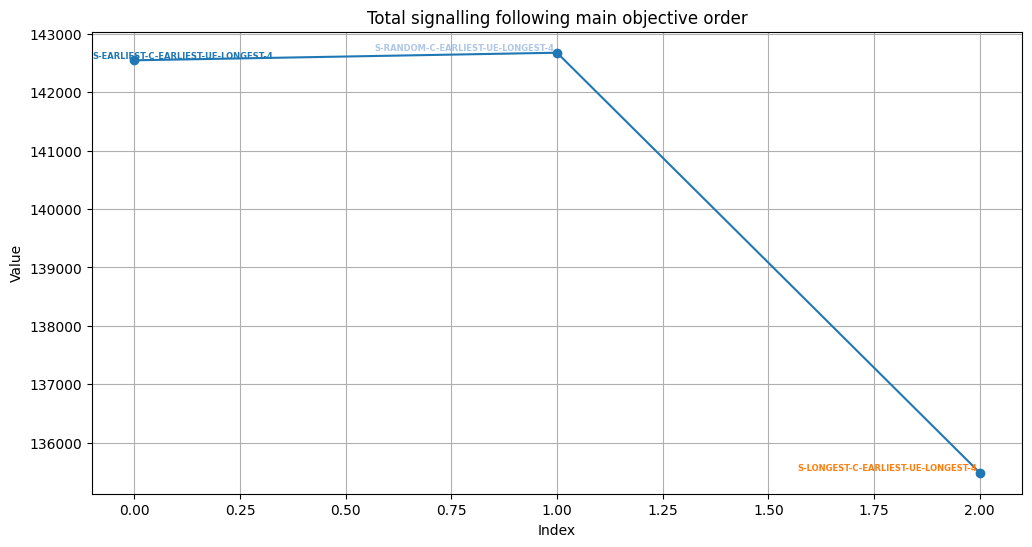

During busy time (top 25%), are we making the busy time more busy?


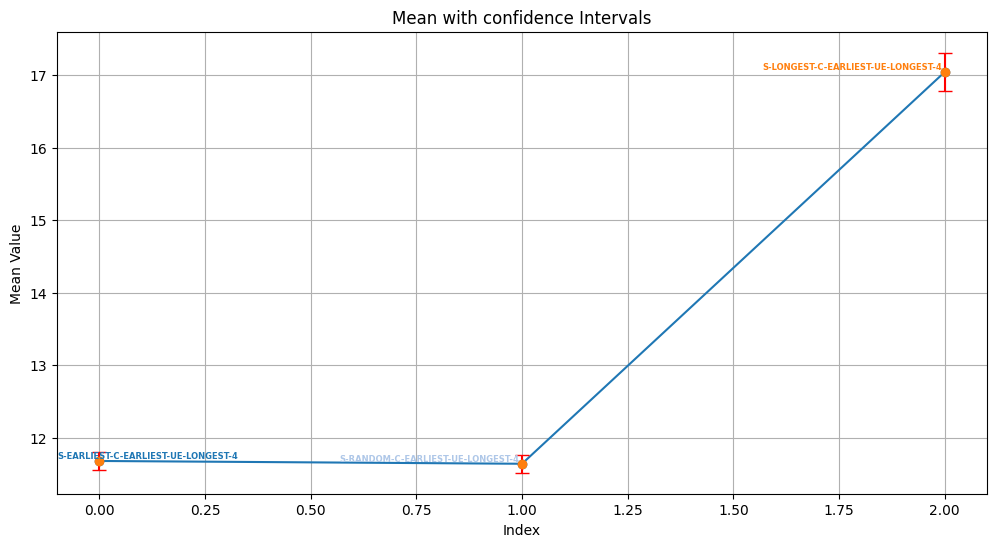

In [2]:
draw_numerical_result(result)

Are there certain satellites experiencing higher signalling peaks than others?


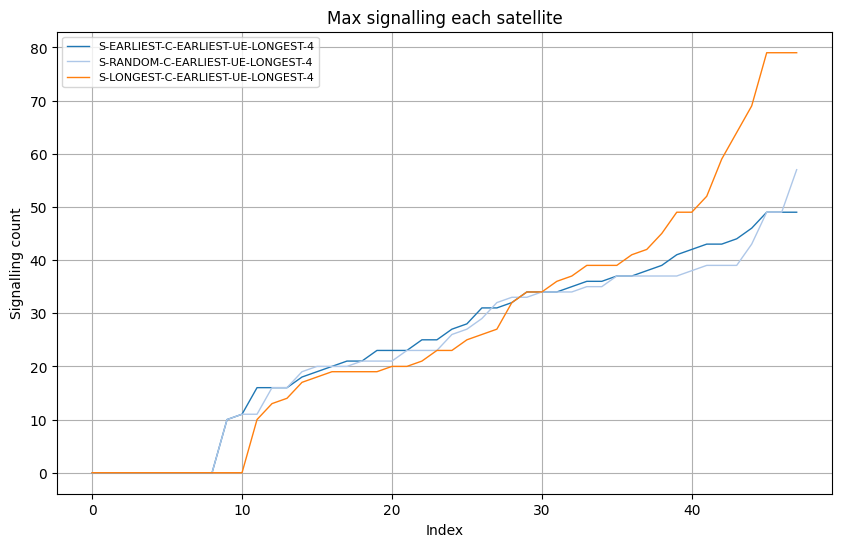

In [3]:
# The figure describes the maximum signalling of each satellite
draw_max_signalling(result)

Given a signalling load, is the method showing that majority of the time slots are under the expected threshold?


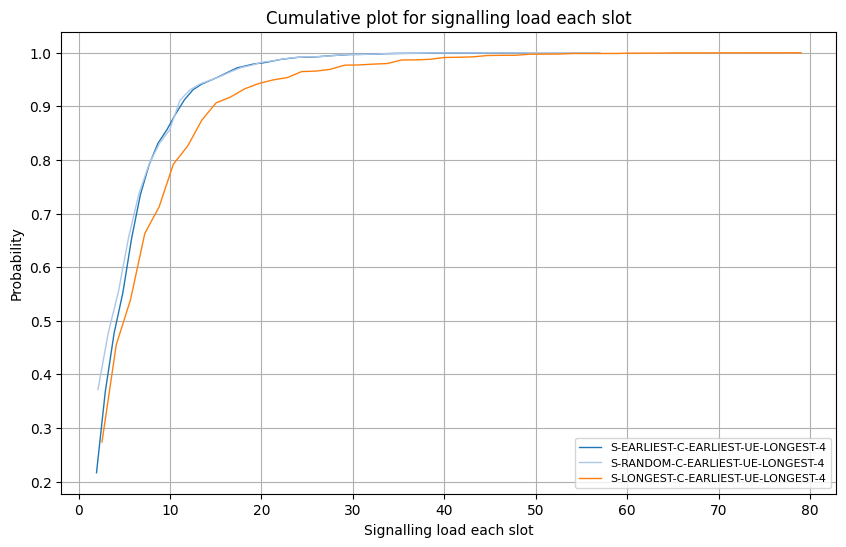

In [4]:
draw_cumulative_load_each_time(result)

Are there certain satellites handling much more signalling than others?


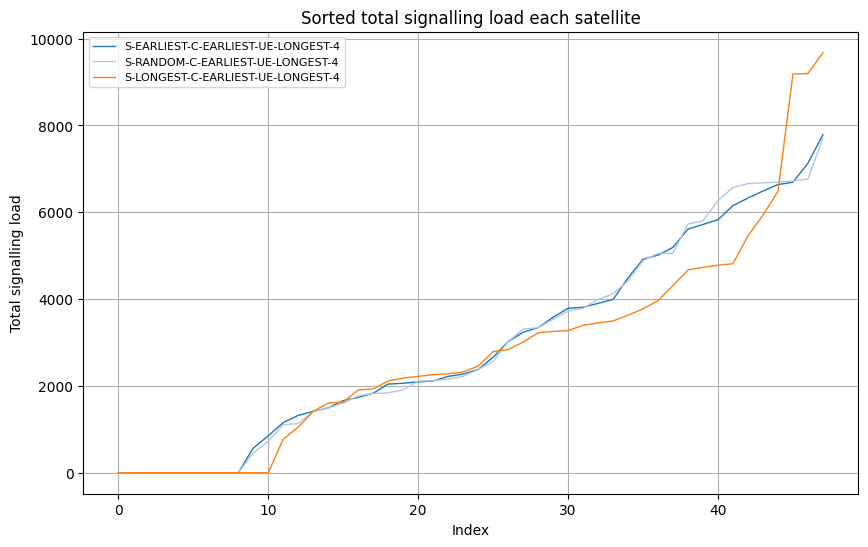

In [5]:
draw_total_load_each_satellite(result)

Are there certain satellites handling majority of the busy (top 25%) signalling slots? 


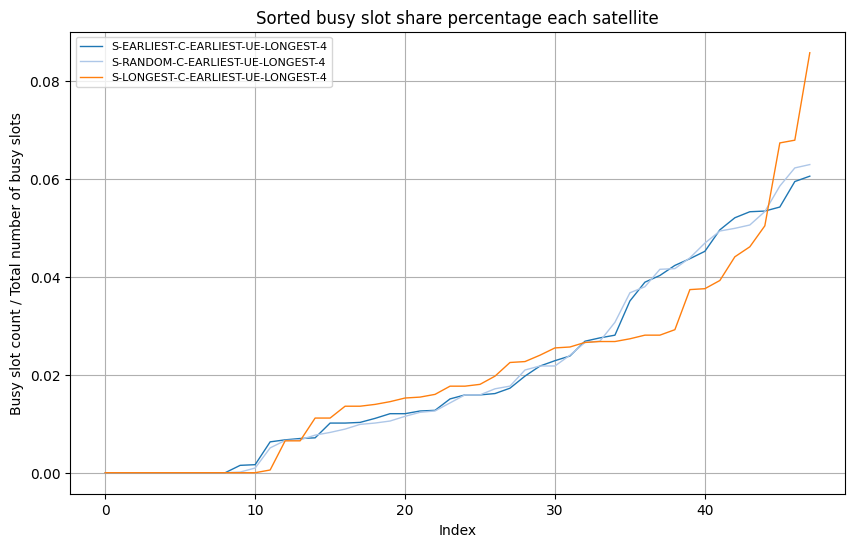

In [6]:
draw_busy_hour_distribution(result)

Are certain satellites experienced a much higher maximum reservation rate than others?


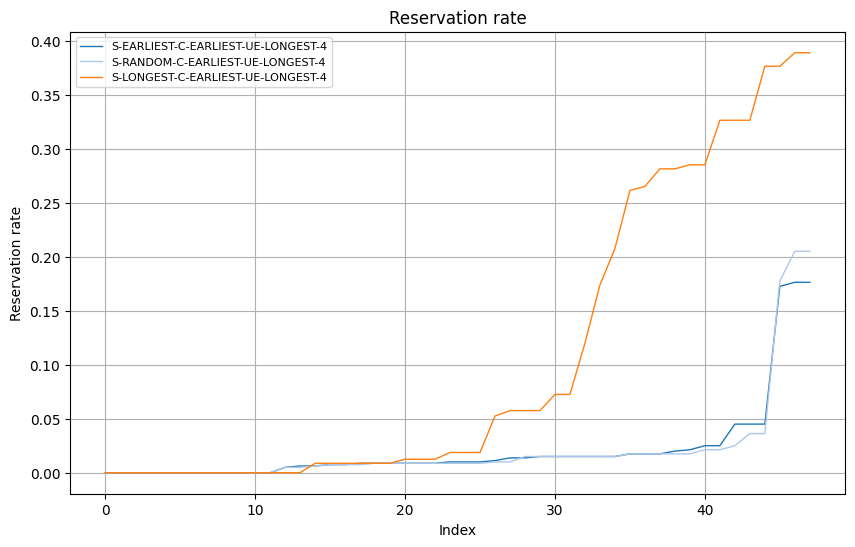

In [7]:
draw_max_reservation(result)

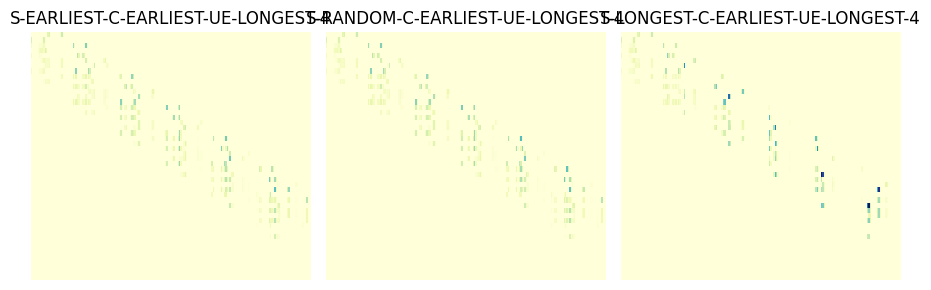

In [8]:
draw_heatmap(result, 100)

In [9]:
#draw_max_access_slot(result)

In [3]:
[1,2,3,4][3:]

[4]